In [26]:
import numpy as np
import pandas as pd
from gwdistributions import parse, generators
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
import numpy as np

/opt/anaconda3/envs/mmms-gw230529/lib/python3.11/site-packages/gwdistributions/utils/cosmology.py:178: RuntimeWarning: divide by zero encountered in log
  return be.log(4*be.pi) + 2*be.log(Dc) + be.log(self.dDcdz(z))
100%|██████████| 50/50 [00:01<00:00, 26.09it/s]


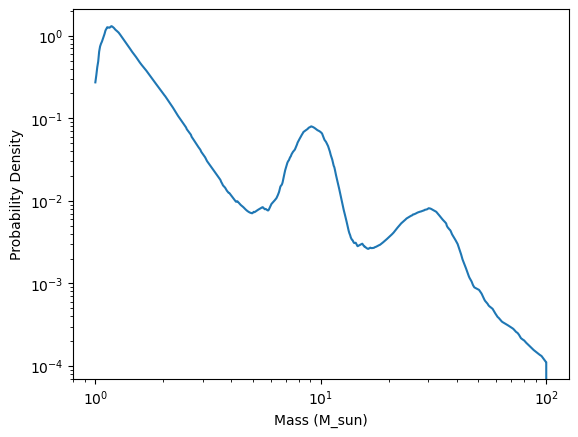

In [27]:
# Hardcoded file path
filename = "../../conversion_scripts/multiPDB_betaSplit_brokenG/population.csv.gz"

# Read and print the table
df = pd.read_csv(filename, compression='gzip')
df["notch_amplitude"] = df["notch_amplitude"].astype(float)
df["notch_lowmass_exponent"] = df["notch_lowmass_exponent"].astype(float)
df.head()["notch_amplitude"]
converted_posterior_samples = df.to_dict(orient="list")
# read ../conversion_dictionaries/multiPDB_betaSplit_brokenG.txt as dict file
with open("../../conversion_dictionaries/multiPDB_betaSplit_brokenG.txt", "r") as f:
    conversion_dict = ast.literal_eval(f.read())

samples = []
num_hyperparams = len(conversion_dict)
num_samples = len(converted_posterior_samples["notch_amplitude"])

for i in range(num_samples):
    sample_dict = {}
    for key, value in converted_posterior_samples.items():
        sample_dict[key] = value[i]
    samples.append(sample_dict)
assert len(samples) == num_samples, f"Expected 5000 samples, but got {len(samples)}"
assert len(samples[0]) == num_hyperparams, f"Expected each dictionary to have {num_hyperparams} keys, but got {len(samples[0])}"


EG = generators.EventGenerator(*parse.parse_config("multiPDB_betaSplit_brokenG.ini"))
mass_dist2d = EG.variate2distribution("mass1_source")
mass_dist1d = mass_dist2d.massdist

n_samples = int(len(samples)/100)

p_m_arr = np.zeros((n_samples, 10000))

for i, s in tqdm(enumerate(samples[:n_samples]), total=n_samples):
    EG.update(**s)
    # mass_grid = np.logspace(0, 1.999, 1000)
    mass_grid = np.linspace(1, 100, 10000)  # Adjusted for better resolution
    p_m = mass_dist1d.prob(mass_grid)
    p_m_arr[i] = p_m
p_m50 = np.median(p_m_arr, axis=0)
plt.plot(mass_grid, p_m50)
plt.xscale("log")
plt.xlabel("Mass (M_sun)")
plt.ylabel("Probability Density")
plt.yscale("log")

In [28]:
import h5py

# Read in BGP results
path = "../gppop_m1m2_popsummary_ifar4_ulogm.hdf5"

with h5py.File(path, 'r') as f:
    m1 = f["posterior"]["rates_on_grids"]["primary_mass"]
    m2 = f["posterior"]["rates_on_grids"]["secondary_mass"]
    m1_grid = m1["positions"][:]
    m2_grid = m2["positions"][:]
    m1_rates = m1["rates"][:]
    m2_rates = m2["rates"][:]


In [29]:
# p_m_arr = m1_rates
# n_samples = len(m1_rates)
# mass_grid = m1_grid.squeeze()
# p_m50 = np.median(p_m_arr, axis=0)
# plt.plot(mass_grid, p_m50)
# # plt.xlim(1, 3)
# plt.xscale("log")
# plt.xlabel("Mass (M_sun)")
# plt.ylabel("Probability Density")
# plt.yscale("log")

In [30]:
from scipy.signal import convolve

# kernel = np.array([1, 0, -1, 0, 1]) # 80/100
kernel1 = np.array([-1, -2,  0,  2,  1])
kernel2 = np.array([1, -2, 1])

passed1 = 0
passed2 = 0

for p_m in p_m_arr:
    mask_full = (mass_grid >= 1) & (mass_grid <= 10)
    mass_roi = mass_grid[mask_full]
    p_m_roi = p_m[mask_full]
    filtered = convolve(np.log10(p_m_roi), kernel1, mode='same')
    search_mask = (mass_roi >= 1.8) & (mass_roi <= 5)
    filtered_search = filtered[search_mask]
    mass_search = mass_roi[search_mask]
    edge_idx_local = np.argmax(np.abs(filtered_search))
    mtov = mass_search[edge_idx_local]

    if mtov > 2 and mtov < 4.9:
        passed1 += 1
    else:
        filtered = convolve(np.log10(p_m_roi), kernel2, mode='same')
        search_mask = (mass_roi >= 1.8) & (mass_roi <= 5)
        filtered_search = filtered[search_mask]
        mass_search = mass_roi[search_mask]
        edge_idx_local = np.argmax(np.abs(filtered_search))
        mtov = mass_search[edge_idx_local]
        if mtov > 2 and mtov < 4.9:
            passed2 += 1


    lab = f"Edge detected at mass: {mtov:.3f}"

    # plt.figure()
    # plt.plot(mass_grid, p_m)
    # plt.title(lab)
    # plt.xscale("log") ; plt.xlabel("Mass (M_sun)")
    # plt.axvline(x=mtov, color='r', linestyle='--', label='M_tov')
    # plt.ylabel("Probability Density")
    # plt.yscale("log")

score = passed1 + passed2

print(f"Number of samples with M_tov > 2: Stage 1 {passed1} out of {n_samples}")
print(f"Number of samples with M_tov > 2: Stage 2 {passed1 + passed2} out of {n_samples}")

Number of samples with M_tov > 2: Stage 1 21 out of 50
Number of samples with M_tov > 2: Stage 2 42 out of 50


In [31]:
import torch
import numpy as np
from scipy.signal import convolve

def evaluate_kernel(kernel2_np):
    kernel1 = np.array([-1, -2,  0,  2,  1])
    passed1 = 0
    passed2 = 0

    for p_m in p_m_arr:
        mask_full = (mass_grid >= 1) & (mass_grid <= 10)
        mass_roi = mass_grid[mask_full]
        p_m_roi = p_m[mask_full]
        filtered = convolve(np.log10(p_m_roi), kernel1, mode='same')
        search_mask = (mass_roi >= 1.8) & (mass_roi <= 5)
        filtered_search = filtered[search_mask]
        mass_search = mass_roi[search_mask]
        edge_idx_local = np.argmax(np.abs(filtered_search))
        mtov = mass_search[edge_idx_local]

        if mtov > 2 and mtov < 4.9:
            passed1 += 1
        else:
            filtered = convolve(np.log10(p_m_roi), kernel2_np, mode='same')
            search_mask = (mass_roi >= 1.8) & (mass_roi <= 5)
            filtered_search = filtered[search_mask]
            mass_search = mass_roi[search_mask]
            edge_idx_local = np.argmax(np.abs(filtered_search))
            mtov = mass_search[edge_idx_local]
            if mtov > 2 and mtov < 4.9:
                passed2 += 1

    return passed1 + passed2

def optimize_kernel(grad_slope, epochs=10, lr=1, initial_kernel = None, seed = 0):
    torch.manual_seed(seed)
    kernel_length = 3

    if initial_kernel is not None:
        kernel = torch.tensor(initial_kernel, dtype=torch.float32, requires_grad=True)
        if kernel.shape[0] != kernel_length:
            raise ValueError(f"Initial kernel length must be {kernel_length}")
    else:
        kernel = torch.randn(kernel_length, requires_grad=True)
    optimizer = torch.optim.Adam([kernel], lr=lr)

    best_score = -1
    best_kernel = None

    for epoch in range(epochs):
        optimizer.zero_grad()
        kernel_np = kernel.detach().cpu().numpy()

        # Dummy loss to use optimizer (using heuristic gradient)
        dummy_loss = -torch.sum(kernel * 0)
        dummy_loss.backward()
        kernel.grad = -torch.sign(kernel) * grad_slope
        optimizer.step()
        score = evaluate_kernel(kernel_np)

        # print(f"Slope {grad_slope} Epoch {epoch+1:02d}: Score = {evaluate_kernel(kernel_np)}")
        if score > best_score:
            best_score = score
            best_kernel = kernel.detach().cpu().numpy().copy()


    return best_kernel, best_score

# Multi-start optimization
overall_best_score = -1
overall_best_kernel = None

for grad_slope in np.logspace(-15, -10, 5):
    print(f"\nStarting optimization run with learning: {grad_slope}")
    kernel, score = optimize_kernel(grad_slope, initial_kernel = np.array([1, -2, 1]))
    print(f"Run slope {grad_slope} best score: {score}")
    if score > overall_best_score:
        overall_best_score = score
        overall_best_kernel = kernel
        overall_best_slope = grad_slope

print(f"\nOverall best score: {overall_best_score}")
print(f"Overall best kernel2: {overall_best_kernel}")
print(f"Overall best slope: {overall_best_slope}")



Starting optimization run with learning: 1e-15
Run slope 1e-15 best score: 42

Starting optimization run with learning: 1.7782794100389227e-14
Run slope 1.7782794100389227e-14 best score: 41

Starting optimization run with learning: 3.162277660168379e-13
Run slope 3.162277660168379e-13 best score: 44

Starting optimization run with learning: 5.6234132519034904e-12
Run slope 5.6234132519034904e-12 best score: 36

Starting optimization run with learning: 1e-10
Run slope 1e-10 best score: 29

Overall best score: 44
Overall best kernel2: [ 1.0000316 -2.0000317  1.0000316]
Overall best slope: 3.162277660168379e-13


/var/folders/hr/fxn20ncj0qq2_mtm8k66bl7r0000gn/T/ipykernel_20272/4156306445.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Number of samples with M_tov > 2: Stage 1 21 out of 50
Number of samples with M_tov > 2: Stage 2 44 out of 50


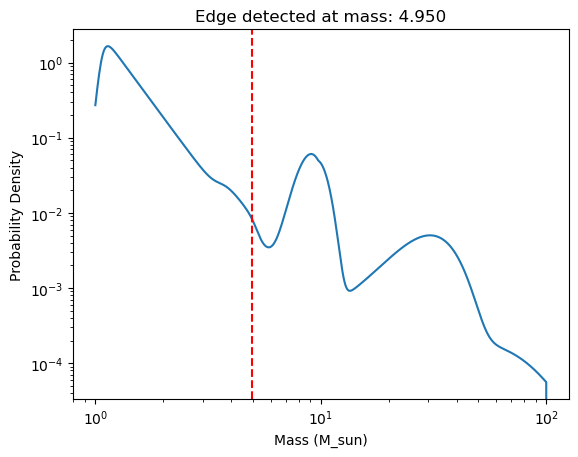

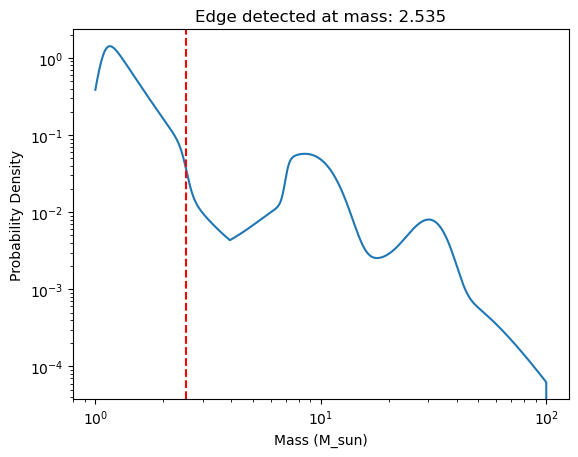

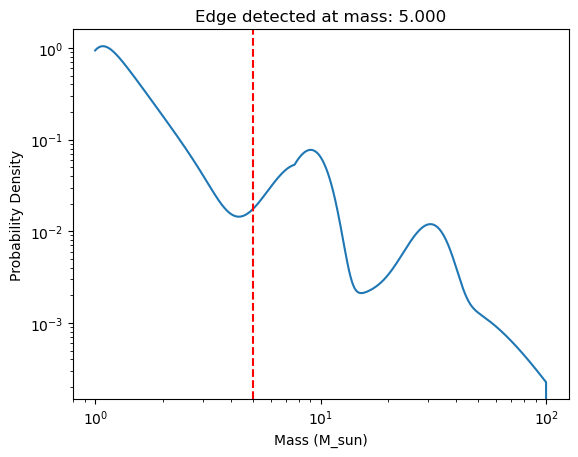

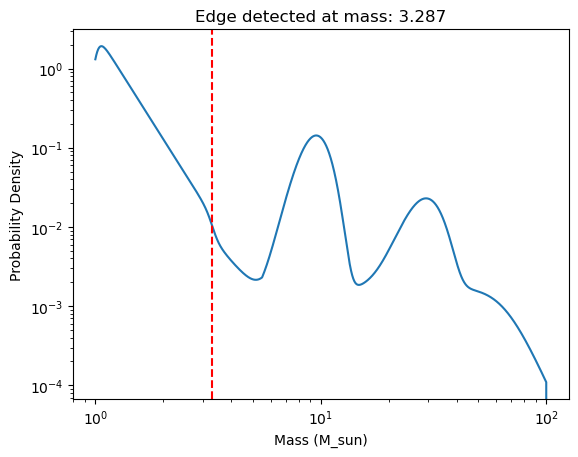

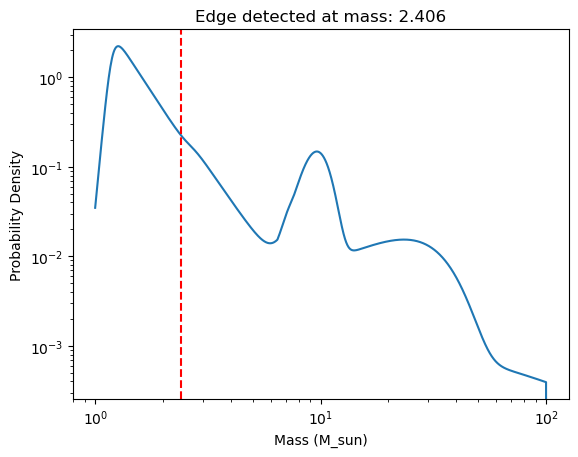

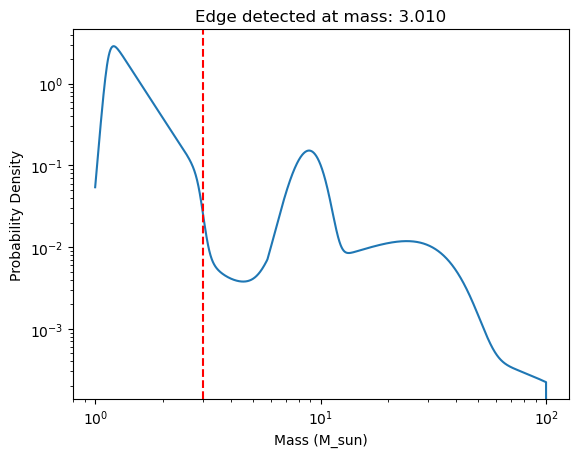

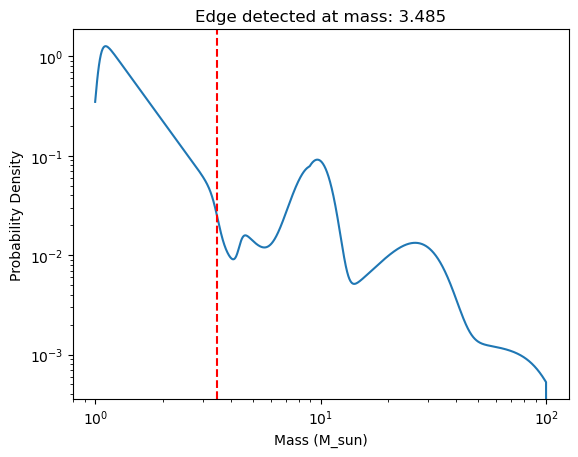

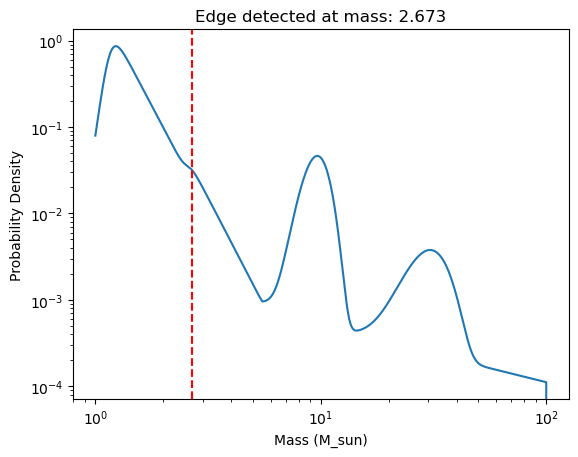

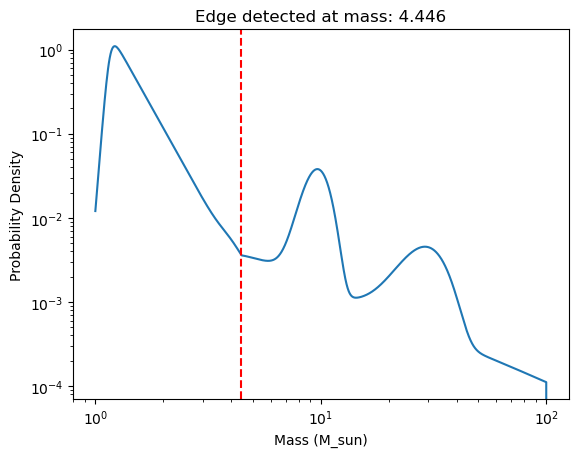

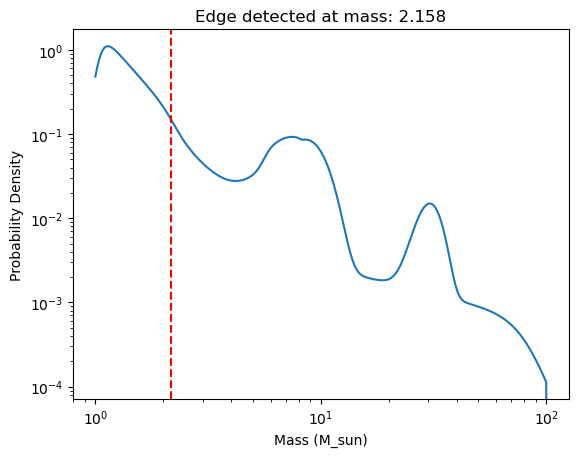

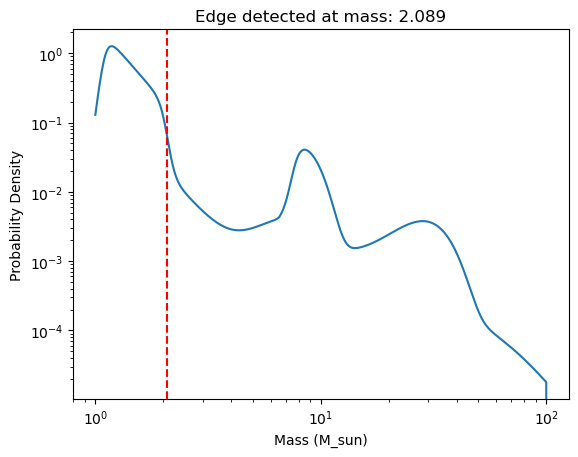

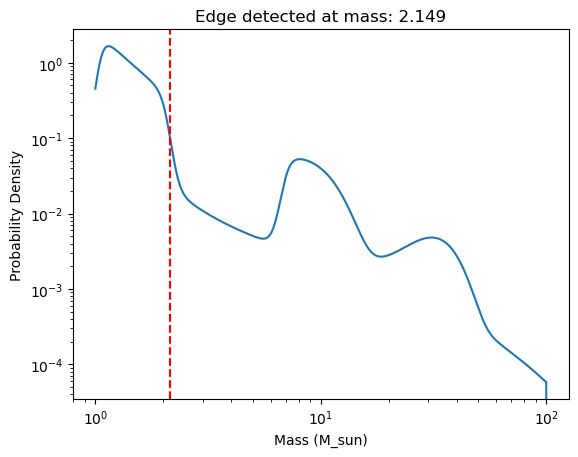

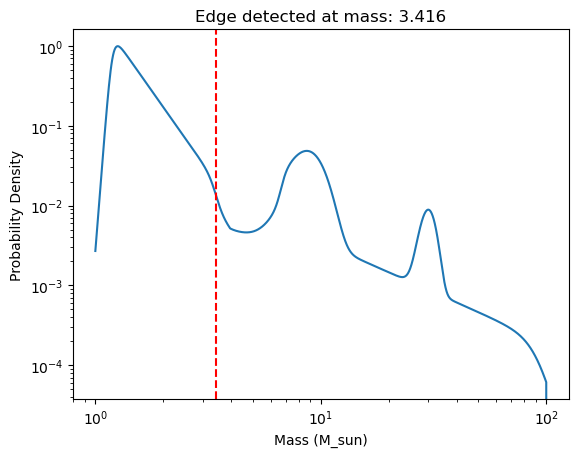

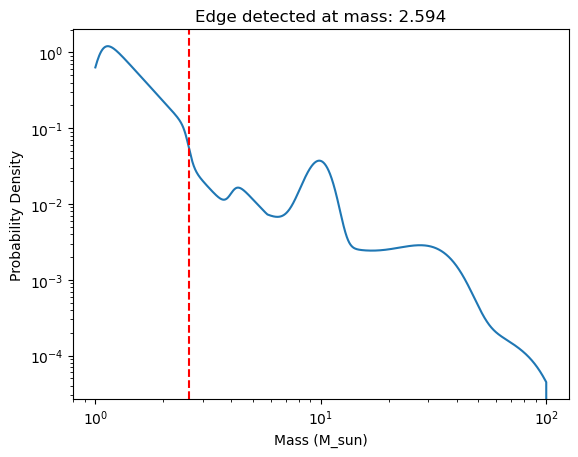

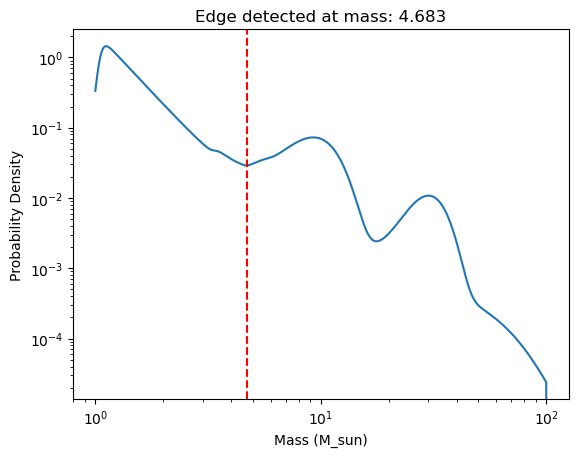

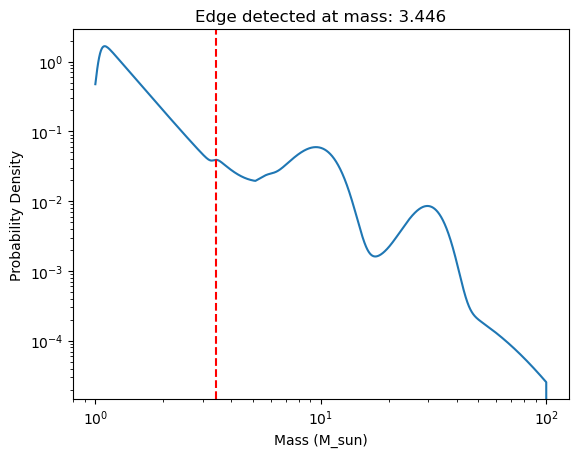

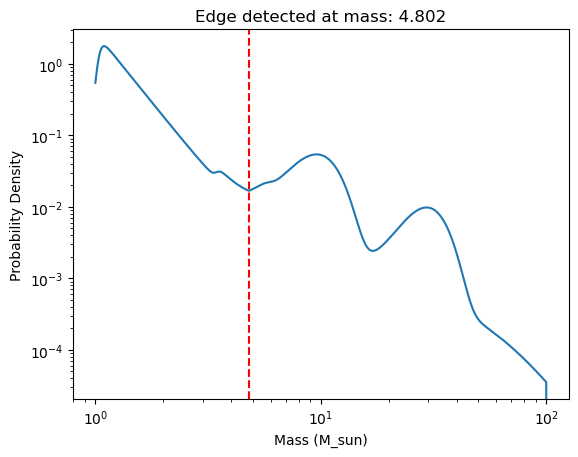

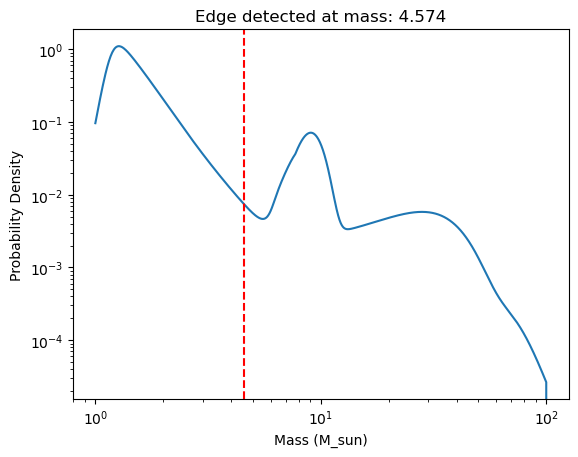

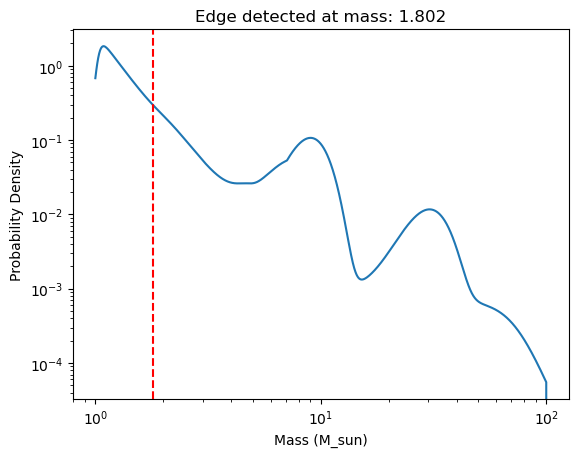

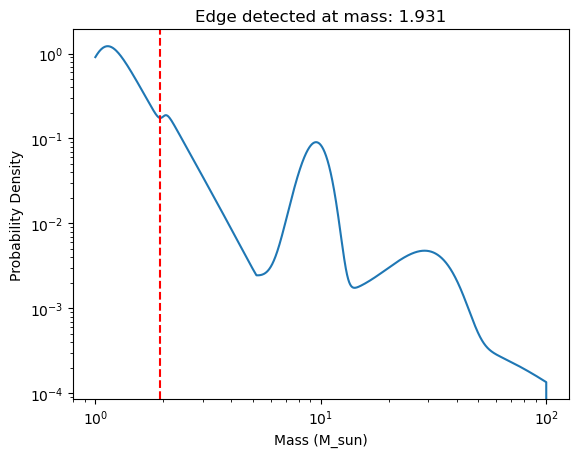

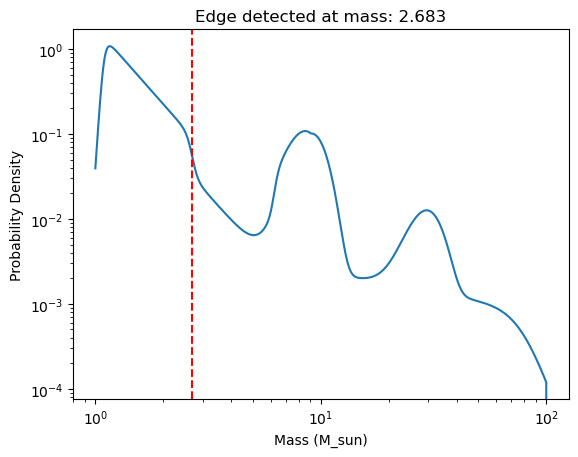

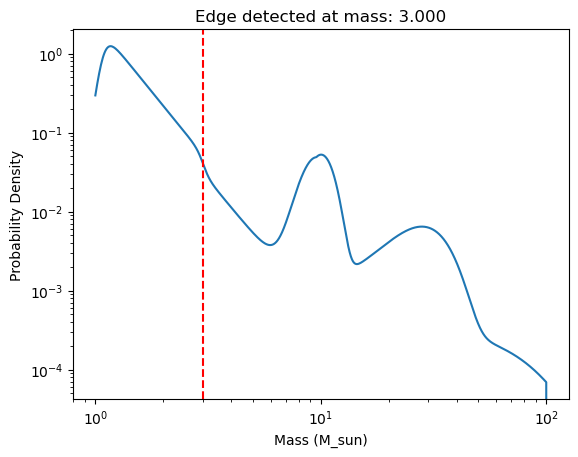

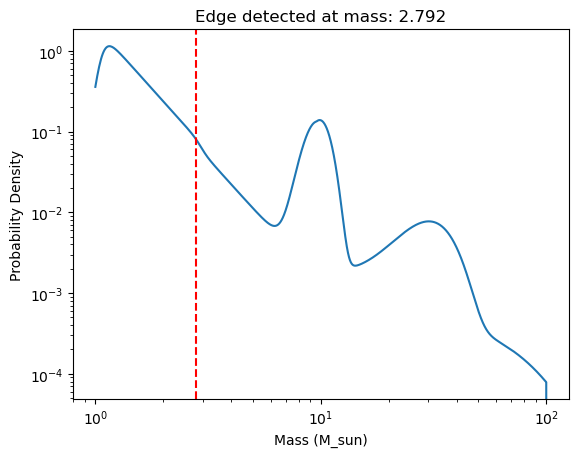

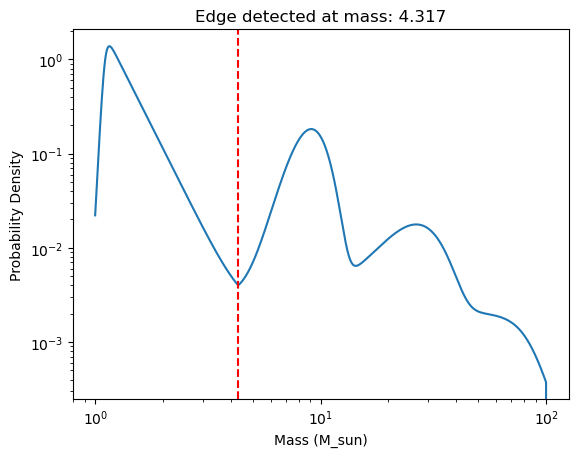

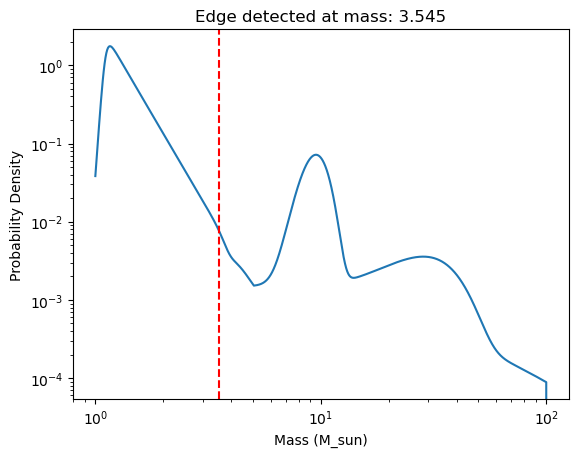

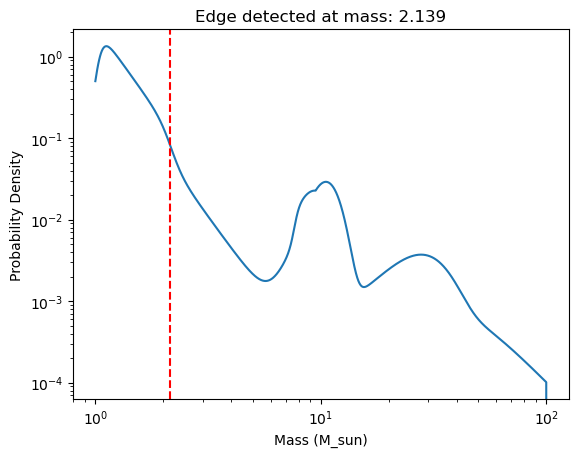

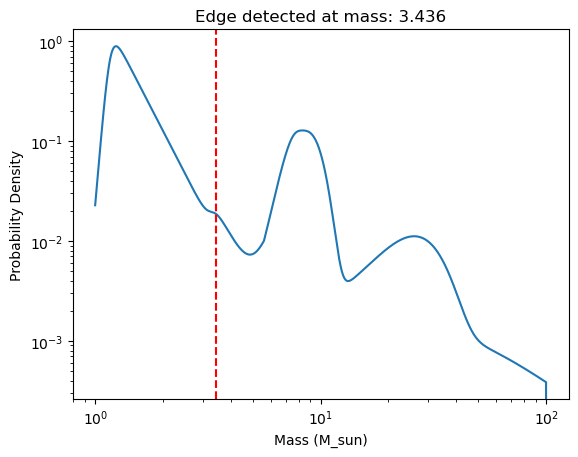

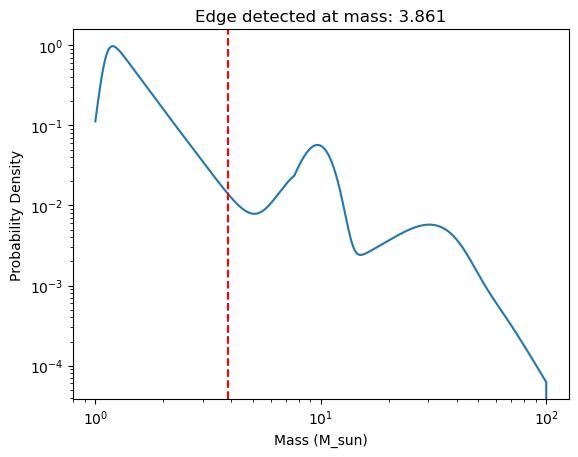

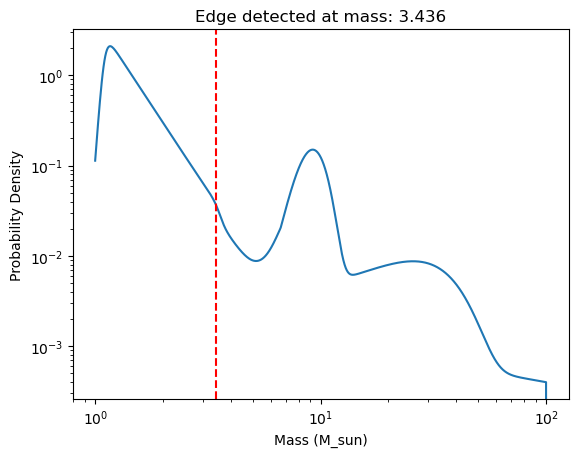

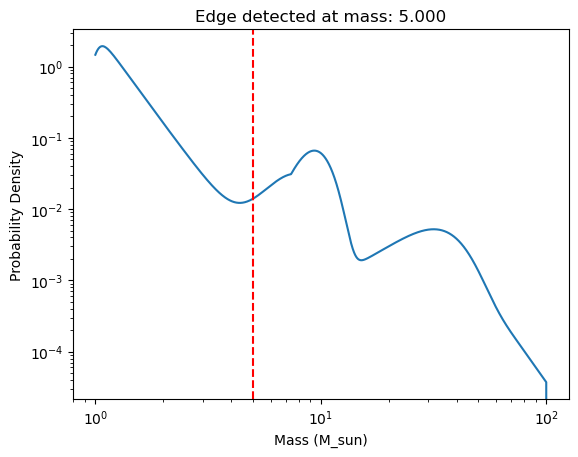

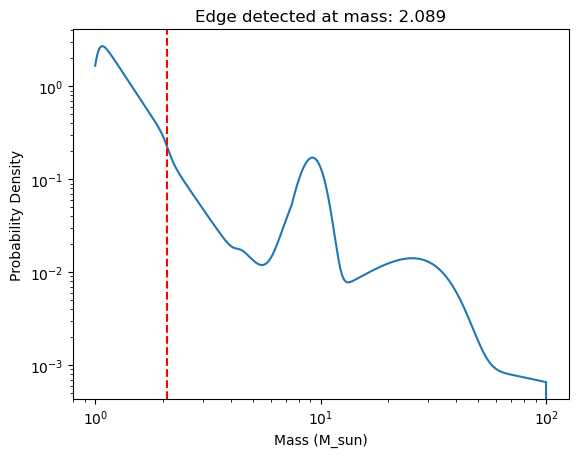

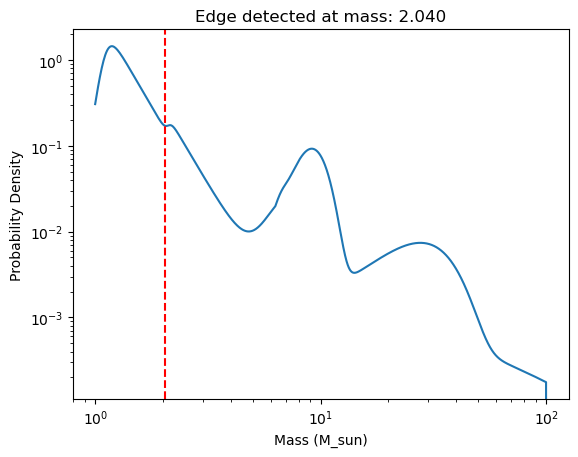

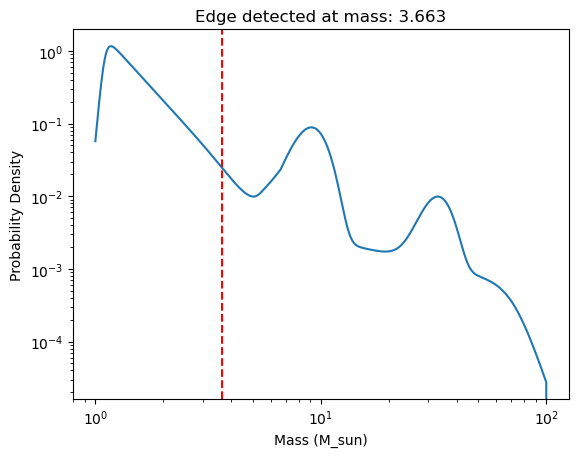

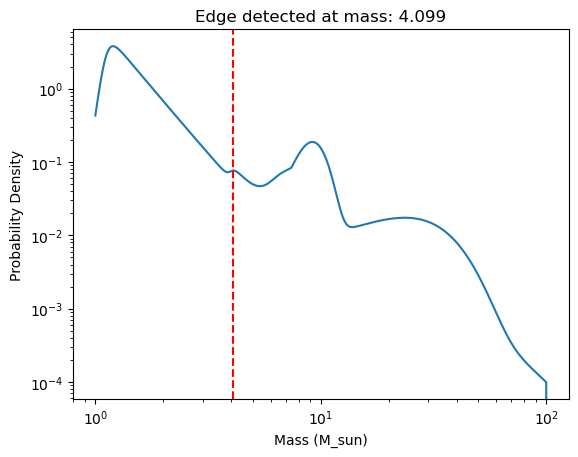

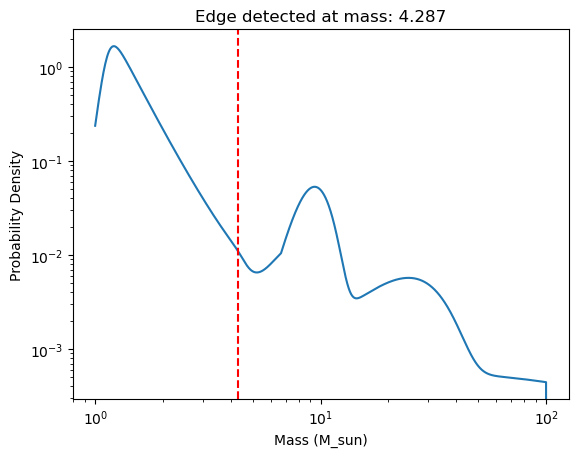

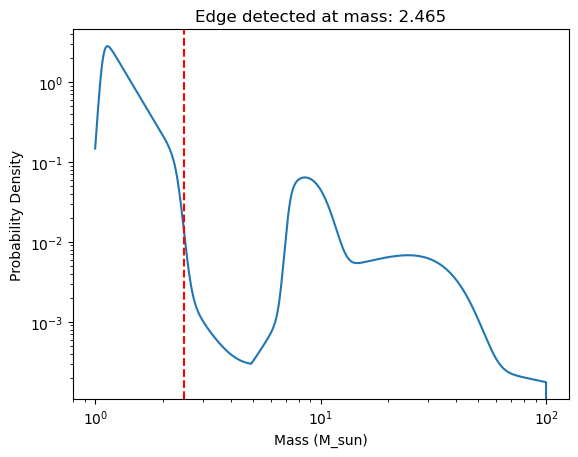

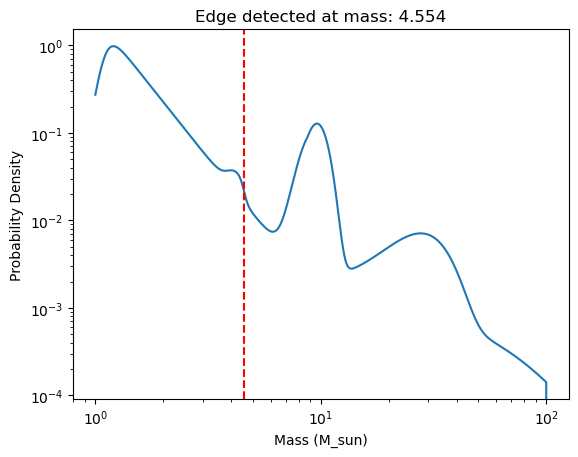

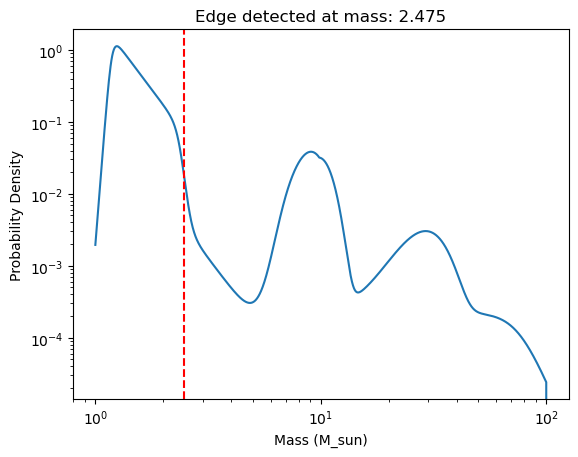

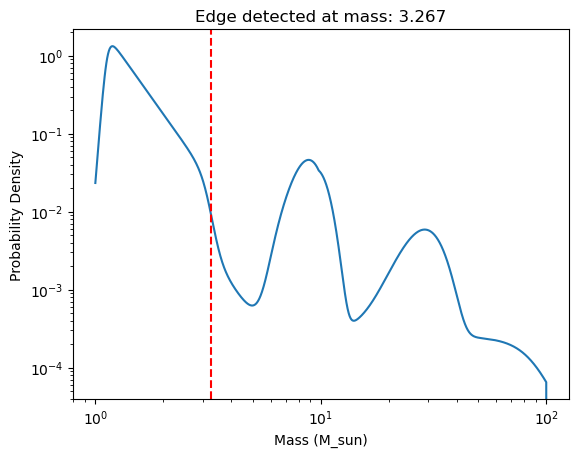

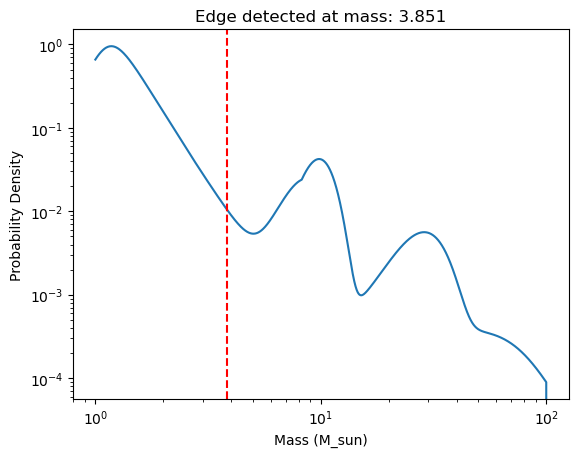

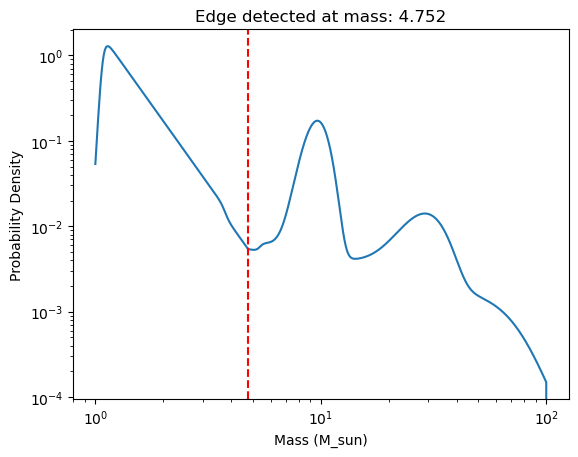

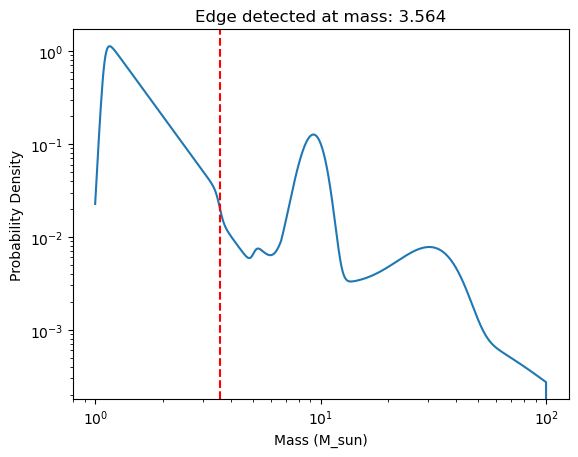

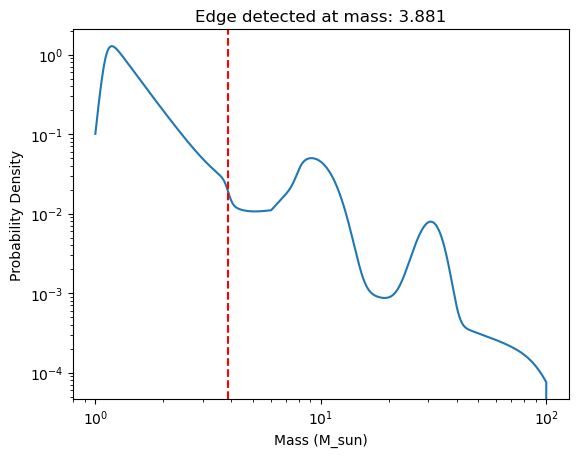

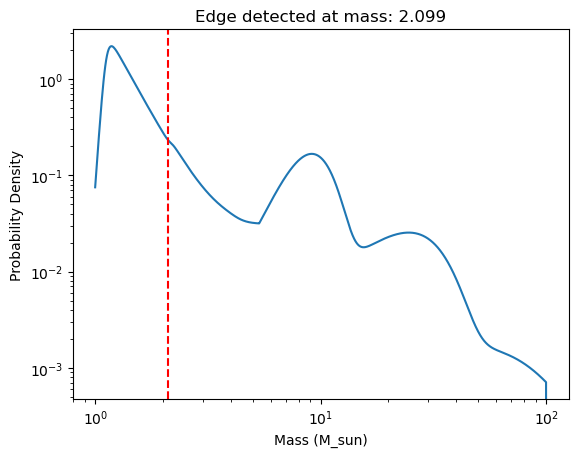

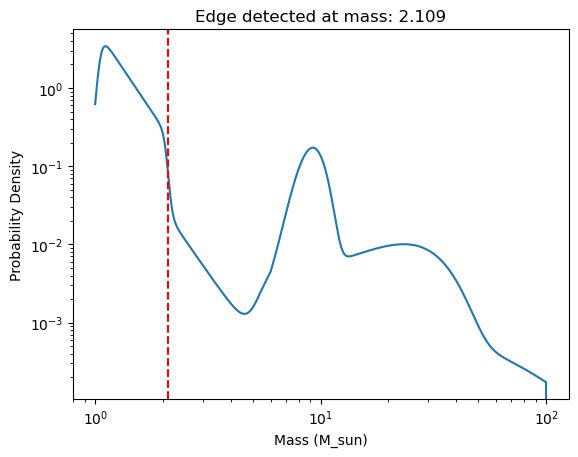

In [32]:
from scipy.signal import convolve

kernel1 = np.array([-1, -2,  0,  2,  1])
kernel2 = overall_best_kernel

passed1 = 0
passed2 = 0

for p_m in p_m_arr:
    mask_full = (mass_grid >= 1) & (mass_grid <= 10)
    mass_roi = mass_grid[mask_full]
    p_m_roi = p_m[mask_full]
    filtered = convolve(np.log10(p_m_roi), kernel1, mode='same')
    search_mask = (mass_roi >= 1.8) & (mass_roi <= 5)
    filtered_search = filtered[search_mask]
    mass_search = mass_roi[search_mask]
    edge_idx_local = np.argmax(np.abs(filtered_search))
    mtov = mass_search[edge_idx_local]

    if mtov > 2 and mtov < 4.9:
        passed1 += 1
    else:
        filtered = convolve(np.log10(p_m_roi), kernel2, mode='same')
        search_mask = (mass_roi >= 1.8) & (mass_roi <= 5)
        filtered_search = filtered[search_mask]
        mass_search = mass_roi[search_mask]
        edge_idx_local = np.argmax(np.abs(filtered_search))
        mtov = mass_search[edge_idx_local]
        if mtov > 2 and mtov < 4.9:
            passed2 += 1


    if (passed1 > 20) or (passed2 > 20):
        continue
    lab = f"Edge detected at mass: {mtov:.3f}"
    plt.figure()
    plt.plot(mass_grid, p_m)
    plt.title(lab)
    plt.xscale("log") ; plt.xlabel("Mass (M_sun)")
    plt.axvline(x=mtov, color='r', linestyle='--', label='M_tov')
    plt.ylabel("Probability Density")
    plt.yscale("log")


print(f"Number of samples with M_tov > 2: Stage 1 {passed1} out of {n_samples}")
print(f"Number of samples with M_tov > 2: Stage 2 {passed1 + passed2} out of {n_samples}")